In [52]:
# 連接 SQLite 資料庫
conn = sqlite3.connect(r"/Users/ben/Desktop/sqlite-練習題/amazon.db")

# 從資料庫讀取資料表 commerce_data，並指定 CustomerID 為字串型態
df = pd.read_sql_query("SELECT * FROM commerce_data", conn, dtype={'CustomerID': str})

# 關閉連線
conn.close()

# 查看前五筆資料
print(df.head())

# 查看資料維度
print("資料形狀:", df.shape)

# 查看欄位資訊與缺失值狀況
print(df.info())

# 計算每欄位缺失比例
missing_ratio = df.isnull().mean()
print("缺失比例:\n", missing_ratio)

# 移除 Description 欄位（如果存在）
if 'Description' in df.columns:
    df.drop(['Description'], axis=1, inplace=True)

# 再次查看前五筆確認刪除成功
print(df.head())

# 將 CustomerID 缺失值填補為 'Unknown'
df['CustomerID'] = df['CustomerID'].fillna('Unknown')

# 把空字串（空白）也轉成 'Unknown'
df['CustomerID'] = df['CustomerID'].replace(r'^\s*$', 'Unknown', regex=True)

# 計算重複行數
print("重複行數:", df.duplicated().sum())

# 去除重複行
df = df.drop_duplicates()

# 查看數值型欄位的描述統計
print(df.describe())

# 確認 Unknown 數量
print("CustomerID 中 'Unknown' 數量:", (df['CustomerID'] == 'Unknown').sum())

  InvoiceNo StockCode                          Description Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER        6   
1    536365     71053                  WHITE METAL LANTERN        6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER        8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE        6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.        6   

      InvoiceDate UnitPrice CustomerID         Country  
0  12/1/2010 8:26      2.55      17850  United Kingdom  
1  12/1/2010 8:26      3.39      17850  United Kingdom  
2  12/1/2010 8:26      2.75      17850  United Kingdom  
3  12/1/2010 8:26      3.39      17850  United Kingdom  
4  12/1/2010 8:26      3.39      17850  United Kingdom  
資料形狀: (541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   InvoiceNo    5

In [53]:
# 數值欄位轉換
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce')

# 過濾異常資料
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]  # 排除退貨單據
df = df[df['Quantity'] > 0]                               # Quantity > 0
df = df[df['UnitPrice'] >= 0]                             # UnitPrice >= 0

# 拆解時間欄位並轉成 datetime
df[['Date', 'Time']] = df['InvoiceDate'].str.split(' ', expand=True)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')
df.drop(columns=['InvoiceDate'], inplace=True)

# 計算每筆交易總額
df['Total'] = df['Quantity'] * df['UnitPrice']

# 確認結果
print("清理後資料筆數:", len(df))
print("CustomerID 'Unknown' 數量:", (df['CustomerID'] == 'Unknown').sum())
print(df[['Quantity', 'UnitPrice', 'Total']].describe())

# 新增欄位判斷是否會員
df['MemberType'] = df['CustomerID'].apply(lambda x: 'Non-Member' if x == 'Unknown' else 'Member')

# 計算各會員類型的訂單數（InvoiceNo 去重計數）
order_counts = df.groupby(['MemberType', 'InvoiceNo']).size().reset_index(name='OrderLines')
order_counts_per_member = order_counts.groupby('MemberType').size()

# 計算各會員類型總購買金額
total_spent = df.groupby('MemberType')['Total'].sum()

# 合併成表
summary = pd.DataFrame({
    'OrderCount': order_counts_per_member,
    'TotalSpent': total_spent
})

print("會員 vs 非會員 購買行為統計：")
print(summary)


清理後資料筆數: 526050
CustomerID 'Unknown' 數量: 133320
            Quantity      UnitPrice          Total
count  526050.000000  526050.000000  526050.000000
mean       10.730375       3.913821      20.229178
std       157.591931      36.053274     271.391492
min         1.000000       0.000000       0.000000
25%         1.000000       1.250000       3.900000
50%         4.000000       2.080000       9.920000
75%        11.000000       4.130000      17.700000
max     80995.000000   13541.330000  168469.600000
會員 vs 非會員 購買行為統計：
            OrderCount   TotalSpent
MemberType                         
Member           18536  8886657.044
Non-Member        2190  1754901.910



回購率 KPI（平均留存率，不含第 0 月）: 21.95%


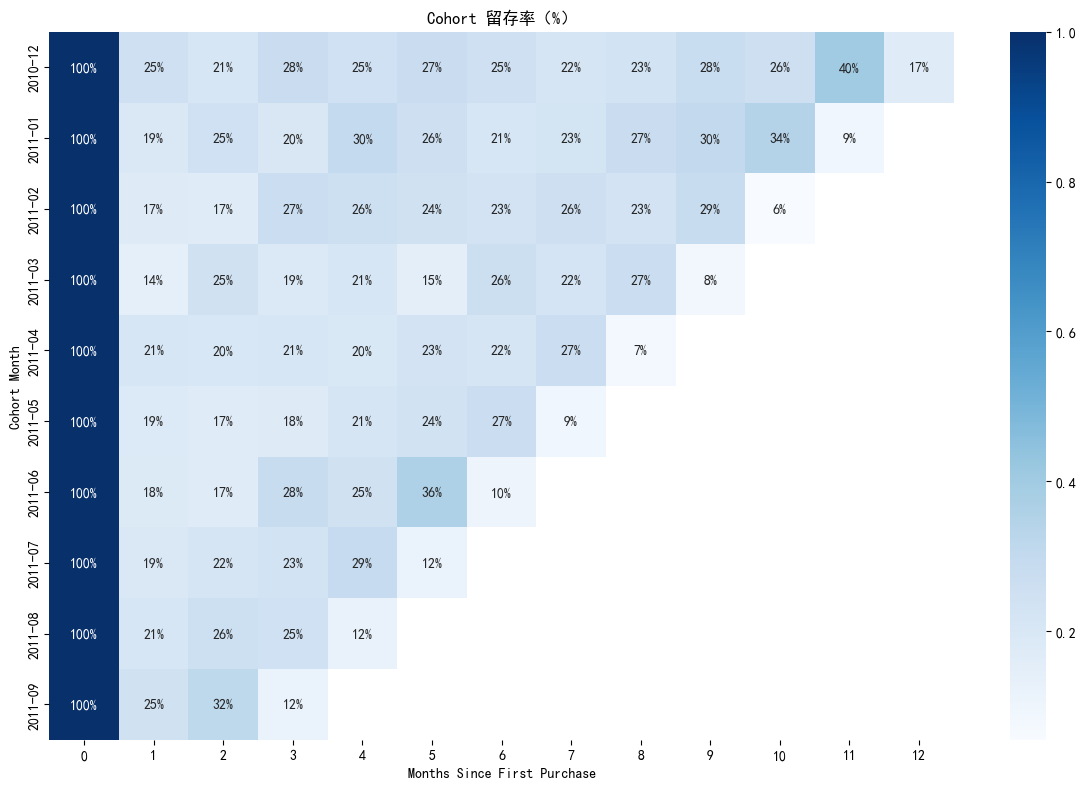

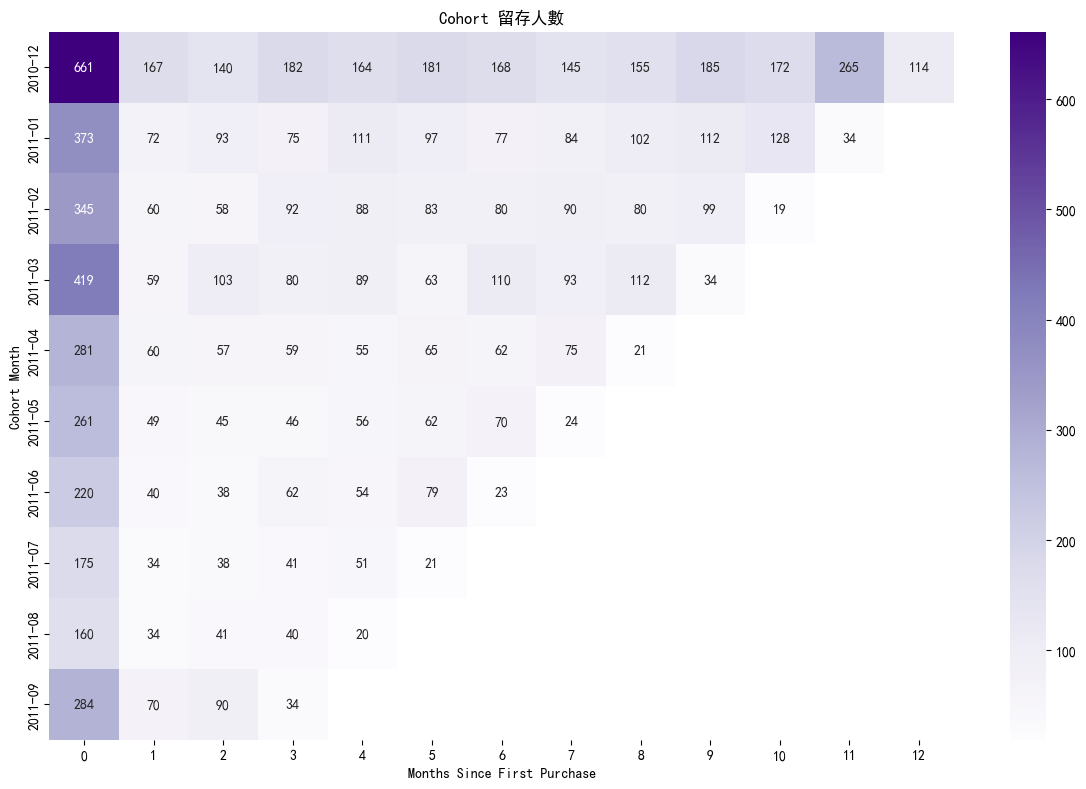

In [80]:
# 日期轉換
df['Date'] = pd.to_datetime(df['Date'])

# 訂單月份
df['OrderMonth'] = df['Date'].dt.to_period('M')

# 首次購買月份 CohortMonth
cohort = df.groupby('CustomerID')['OrderMonth'].min().reset_index()
cohort.columns = ['CustomerID', 'CohortMonth']

# 避免重複欄位衝突
if 'CohortMonth' in df.columns:
    df = df.drop(columns=['CohortMonth'])

df = df.merge(cohort, on='CustomerID')

# 建立 CohortIndex
df['CohortIndex'] = (df['OrderMonth'].dt.year - df['CohortMonth'].dt.year) * 12 + \
                    (df['OrderMonth'].dt.month - df['CohortMonth'].dt.month)

# 每 cohort 每月的活躍顧客數
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()

# 每 cohort 初始人數
cohort_size = cohort_data[cohort_data['CohortIndex'] == 0][['CohortMonth', 'CustomerID']]
cohort_size.columns = ['CohortMonth', 'CohortSize']
cohort_data = cohort_data.merge(cohort_size, on='CohortMonth')

# 計算留存率
cohort_data['RetentionRate'] = cohort_data['CustomerID'] / cohort_data['CohortSize']
cohort_data['CohortMonth'] = cohort_data['CohortMonth'].astype(str)

# 過濾觀察期不足的 cohort
min_observed_months = 3
cohort_validity = df.groupby('CohortMonth')['CohortIndex'].max().reset_index()
cohort_validity.columns = ['CohortMonth', 'MaxIndex']
valid_cohorts = cohort_validity[cohort_validity['MaxIndex'] >= min_observed_months]['CohortMonth'].astype(str)
cohort_data = cohort_data[cohort_data['CohortMonth'].isin(valid_cohorts)]

# ➤ 建立留存率 & 留存人數表格
retention_rate_table = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='RetentionRate')
retention_count_table = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# 平均回購率（剔除 0 月）
kpi_retention = retention_rate_table.iloc[:, 1:].mean().mean()
print(f"\n回購率 KPI（平均留存率，不含第 0 月）: {kpi_retention:.2%}")

# 畫留存率熱力圖
plt.figure(figsize=(12, 8))
sns.heatmap(retention_rate_table, annot=True, fmt='.0%', cmap='Blues')
plt.title('Cohort 留存率（%）')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.tight_layout()
plt.show()

# 畫留存人數熱力圖
plt.figure(figsize=(12, 8))
sns.heatmap(retention_count_table, annot=True, fmt='.0f', cmap='Purples')
plt.title('Cohort 留存人數')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.tight_layout()
plt.show()

In [76]:
#RFM
# 1. 找出每個顧客最後一次消費日期
last_trans_date = df.groupby('CustomerID')['Date'].max()

# 2. 設定參考日期（分析當天的下一天）
snapshot_date = df['Date'].max() + pd.Timedelta(days=1)

# 3. 計算 Recency (距離參考日期的天數)
R = (snapshot_date - last_trans_date).dt.days

# 4. 計算 Frequency (消費頻率，訂單數)
F = df.groupby('CustomerID')['InvoiceNo'].nunique()

# 5. 計算 Monetary (消費金額總和)
M = df.groupby('CustomerID')['Total'].sum()

# 6. 合併成 RFM 表
rfm = pd.DataFrame({
    'Recency': R,
    'Frequency': F,
    'Monetary': M
})

# 7. 使用分位數過濾極端值（例如排除上下1%的極端值）
lower_q = 0.05
upper_q = 0.95

rfm_filtered = rfm[
    (rfm['Frequency'] >= rfm['Frequency'].quantile(lower_q)) &
    (rfm['Frequency'] <= rfm['Frequency'].quantile(upper_q)) &
    (rfm['Monetary'] >= rfm['Monetary'].quantile(lower_q)) &
    (rfm['Monetary'] <= rfm['Monetary'].quantile(upper_q))
].copy()

print(f"原始筆數: {len(rfm)}, 過濾後筆數: {len(rfm_filtered)}")

# 8. 查看過濾後的描述統計
print("過濾後 RFM 描述統計:")
print(rfm_filtered.describe())

# 9. 確認過濾後前幾筆
print("\n過濾後 RFM 資料預覽:")
print(rfm_filtered.head())


# Recency反向百分比排名，越近越大分數（5分為最高）
rfm_filtered['R_Score'] = (1 - rfm_filtered['Recency'].rank(pct=True)) * 5
rfm_filtered['R_Score'] = rfm_filtered['R_Score'].round().astype(int).clip(1,5)

# Frequency正向百分比排名，越頻繁分數越高
rfm_filtered['F_Score'] = rfm_filtered['Frequency'].rank(pct=True) * 5
rfm_filtered['F_Score'] = rfm_filtered['F_Score'].round().astype(int).clip(1,5)

# Monetary正向百分比排名，消費金額越大分數越高
rfm_filtered['M_Score'] = rfm_filtered['Monetary'].rank(pct=True) * 5
rfm_filtered['M_Score'] = rfm_filtered['M_Score'].round().astype(int).clip(1,5)

# 合併成 RFM 分數字串
rfm_filtered['RFM_Score'] = rfm_filtered['R_Score'].astype(str) + \
                            rfm_filtered['F_Score'].astype(str) + \
                            rfm_filtered['M_Score'].astype(str)

rfm_filtered.to_csv("rfm_filtered.csv")

print(rfm_filtered[['Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score']].head(10))


原始筆數: 3832, 過濾後筆數: 3367
過濾後 RFM 描述統計:
           Recency    Frequency     Monetary
count  3367.000000  3367.000000  3367.000000
mean     95.729433     2.797446   900.366381
std      97.783436     1.964620   744.233932
min       1.000000     1.000000   151.850000
25%      22.000000     1.000000   335.995000
50%      58.000000     2.000000   637.500000
75%     145.000000     4.000000  1245.245000
max     374.000000     9.000000  3506.540000

過濾後 RFM 資料預覽:
            Recency  Frequency  Monetary
CustomerID                              
12348            76          4   1797.24
12349            19          1   1757.55
12350           311          1    334.40
12352            37          8   2506.04
12354           233          1   1079.40
            Recency  Frequency  Monetary  R_Score  F_Score  M_Score RFM_Score
CustomerID                                                                   
12348            76          4   1797.24        2        4        4       244
12349            19  

In [56]:
# 畫圖 + 匯出 HTML
fig = px.histogram(rfm_filtered, x='RFM_Score', color='RFM_Score',
                   title='RFM Score 分布',
                   labels={'RFM_Score': 'RFM 分數'},
                   color_discrete_sequence=px.colors.sequential.Viridis)

fig.update_layout(xaxis=dict(categoryorder='category ascending'))
html_path = "/Users/ben/Desktop/rfm_score_plot.html"
fig.write_html(html_path)
webbrowser.open(html_path)

True

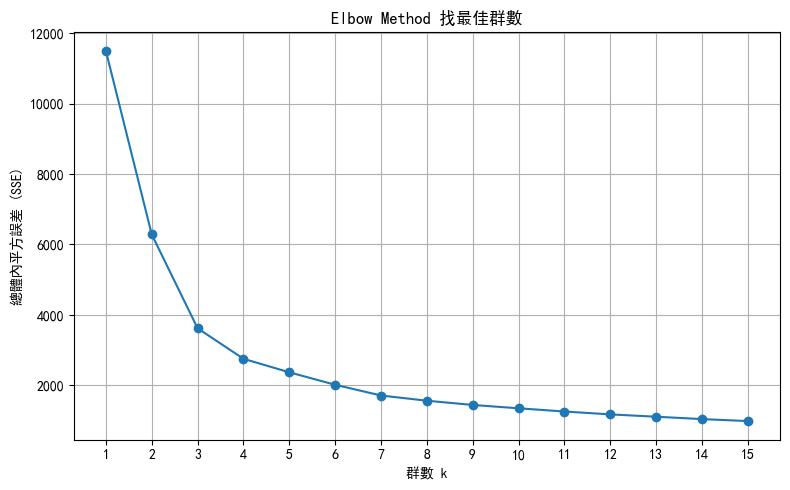

每群統計摘要：
          Recency  Frequency  Monetary  Count
Cluster                                     
0         254.06       1.48    449.31    873
1          39.83       4.91   1702.43    844
2          54.78       1.93    549.07   1742
3          28.06       8.68   3494.93    373
Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score',
       'M_Score', 'RFM_Score', 'Cluster'],
      dtype='object')
   CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0       12347        3          7   4310.00        5        5        5   
1       12348       76          4   1797.24        2        4        4   
2       12349       19          1   1757.55        4        1        4   
3       12350      311          1    334.40        1        1        1   
4       12352       37          8   2506.04        3        5        4   

   RFM_Score  Cluster  
0        555        3  
1        244        1  
2        414        2  
3        111        0  
4        354

In [57]:
# 讀取 RFM 檔案（請替換為你的實際路徑）
rfm = pd.read_csv("/Users/ben/Downloads/rfm_filtered.csv")

# 取出 RFM 數值欄位
rfm_values = rfm[['Recency', 'Frequency', 'Monetary']].copy()

# 標準化
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_values)

# 使用標準化過的 rfm_scaled 進行 Elbow Method 分析
sse = []  # 存每個 k 對應的 inertia（SSE）

# 測試 k 值從 1 到 10
K_range = range(1, 16)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# 設定字體為 SimHei
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 繪製 Elbow 曲線
plt.figure(figsize=(8, 5))
plt.plot(K_range, sse, marker='o')
plt.xticks(K_range)
plt.xlabel('群數 k')
plt.ylabel('總體內平方誤差 (SSE)')
plt.title('Elbow Method 找最佳群數')
plt.grid(True)
plt.tight_layout()
plt.show()


# 執行 KMeans 分群
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 計算每群的平均值與數量
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)
cluster_summary['Count'] = rfm['Cluster'].value_counts().sort_index()
print("每群統計摘要：\n", cluster_summary)

# 匯出 CSV（含分群結果）
rfm.to_csv("/Users/ben/Desktop/rfm_kmeans_segmented.csv", index=False)

# 畫 3D 分群圖
fig = px.scatter_3d(rfm,
                    x='Recency', y='Frequency', z='Monetary',
                    color=rfm['Cluster'].astype(str),
                    title='KMeans RFM 分群（4群）',
                    labels={'Cluster': '群組'},
                    hover_data=['CustomerID', 'RFM_Score'])

# 匯出圖為 HTML 並自動打開
fig.write_html("/Users/ben/Desktop/rfm_kmeans_3d.html")
webbrowser.open("/Users/ben/Desktop/rfm_kmeans_3d.html")

print(rfm.columns)
print(rfm.head())

        Recency                                 Frequency                     \
          count    mean median    std  min  max     count  mean median   std   
Cluster                                                                        
0           873  254.06  249.0  63.23  152  374       873  1.48    1.0  0.83   
1           844   39.83   26.0  39.17    1  236       844  4.91    5.0  1.57   
2          1742   54.78   47.0  39.60    1  158      1742  1.93    2.0  0.93   
3           373   28.06   17.0  36.20    1  265       373  8.68    9.0  2.54   

                Monetary                                               
        min max    count     mean   median      std      min      max  
Cluster                                                                
0         1   7      873   449.31   321.79   405.51   112.20  3811.95  
1         1  10      844  1702.43  1597.74   664.86   201.12  4366.78  
2         1   5     1742   549.07   478.43   338.29   111.68  2062.06  
3      

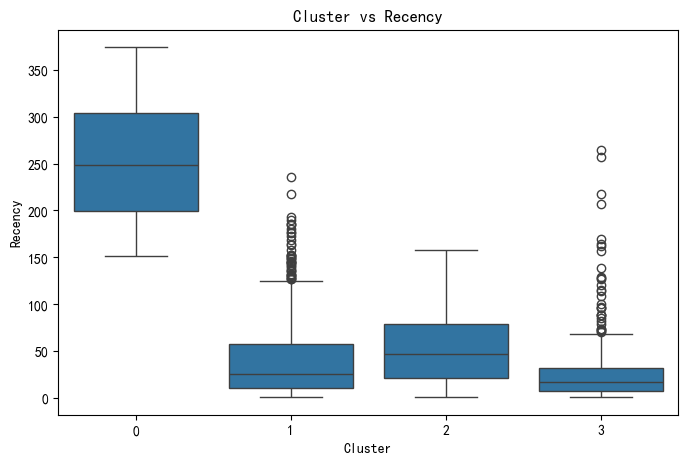

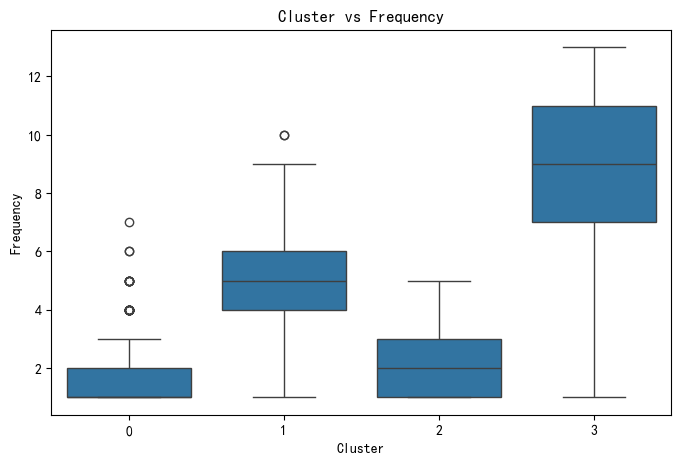

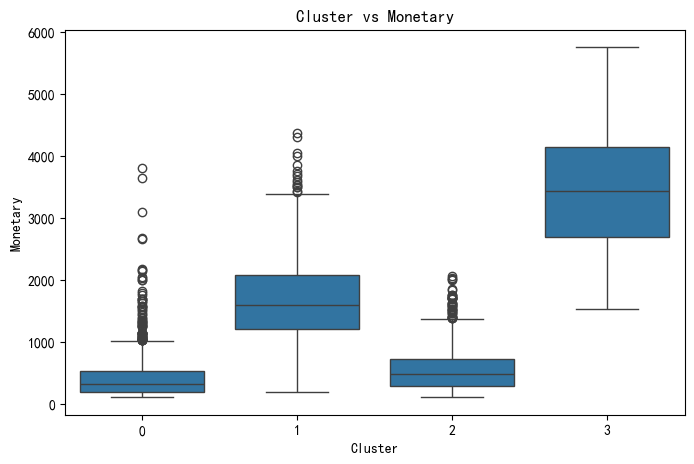

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

desc_stats = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).round(2)

print(desc_stats)

for col in ['Recency', 'Frequency', 'Monetary']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Cluster', y=col, data=rfm)
    plt.title(f'Cluster vs {col}')
    plt.show()

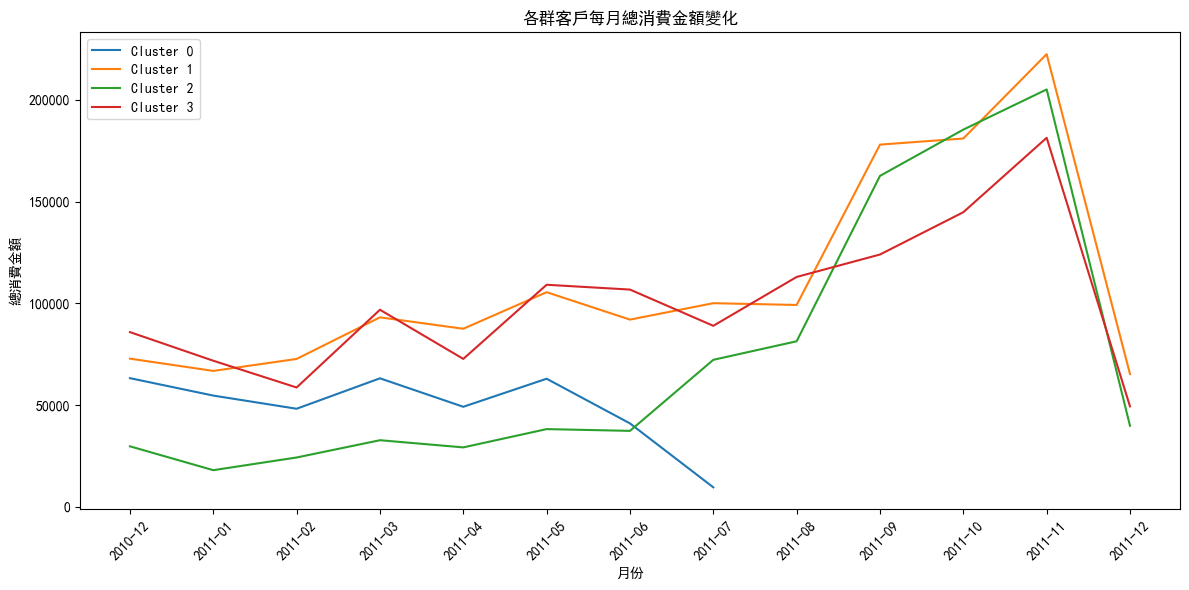

In [59]:
# 將 CustomerID 統一轉成字串型別（
df['CustomerID'] = df['CustomerID'].astype(str)
rfm['CustomerID'] = rfm['CustomerID'].astype(str)

# 把分群結果合併回原始 df（使用 CustomerID 做關聯）
df = df.merge(rfm[['CustomerID', 'Cluster']], on='CustomerID', how='inner')

# 建立月份欄位
df['Month'] = df['Date'].dt.to_period('M')
# 計算每個群集、每月的總消費金額
monthly_cluster = df.groupby(['Cluster', 'Month'])['Total'].sum().reset_index()

# 繪圖
plt.figure(figsize=(12, 6))
for cluster in sorted(monthly_cluster['Cluster'].unique()):
    cluster_data = monthly_cluster[monthly_cluster['Cluster'] == cluster]
    plt.plot(cluster_data['Month'].astype(str), cluster_data['Total'], label=f'Cluster {cluster}')

plt.title("各群客戶每月總消費金額變化")
plt.xlabel("月份")
plt.ylabel("總消費金額")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Cluster
1    92190
3    76041
2    71181
0    23677
Name: count, dtype: int64
各群組分析彙整：
   Cluster  CustomerCount   TotalSales  AvgSalesPerCustomer  Top5Sales  \
0        0            873   392250.200               449.31   24177.90   
1        1            844  1436848.331              1702.43   67304.11   
2        2           1742   956482.633               549.07   42567.46   
3        3            373  1303610.550              3494.93   72164.77   

   Top5Ratio(%)  
0          6.16  
1          4.68  
2          4.45  
3          5.54  

Cluster 0 的熱銷商品 TOP 5：
     StockCode   Total
1139     22423  6638.1
2014     47566  4945.8
2499    85123A  4509.6
1063     22328  4148.4
2729      POST  3936.0

Cluster 1 的熱銷商品 TOP 5：
     StockCode     Total
3018    85123A  15714.95
1205     22423  14962.95
3272      POST  14375.46
3004    85099B  12061.90
2451     47566  10188.85

Cluster 2 的熱銷商品 TOP 5：
     StockCode     Total
3229      POST  10988.30
1197     22423   9972.60
2954    85123A   

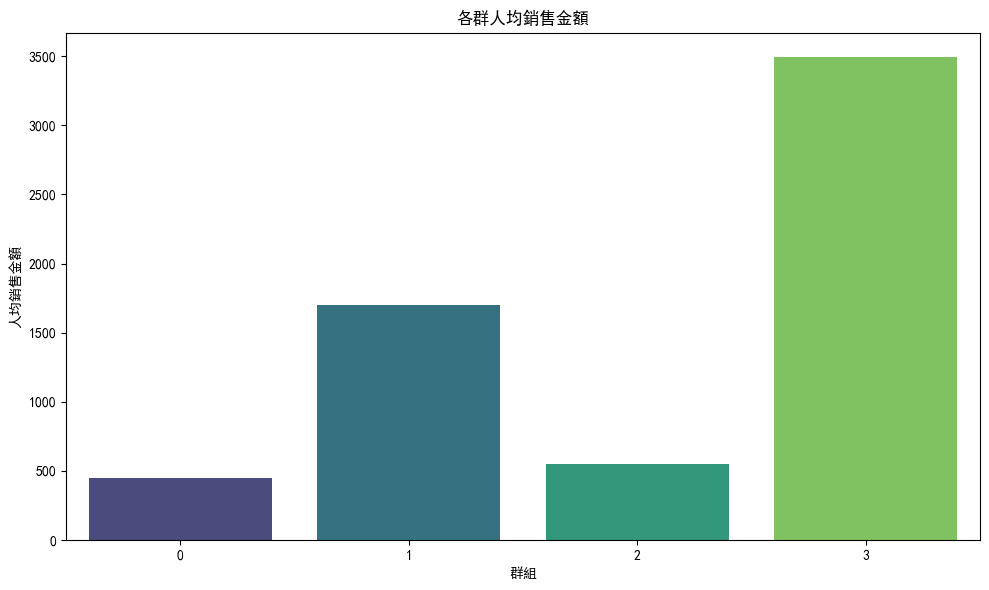

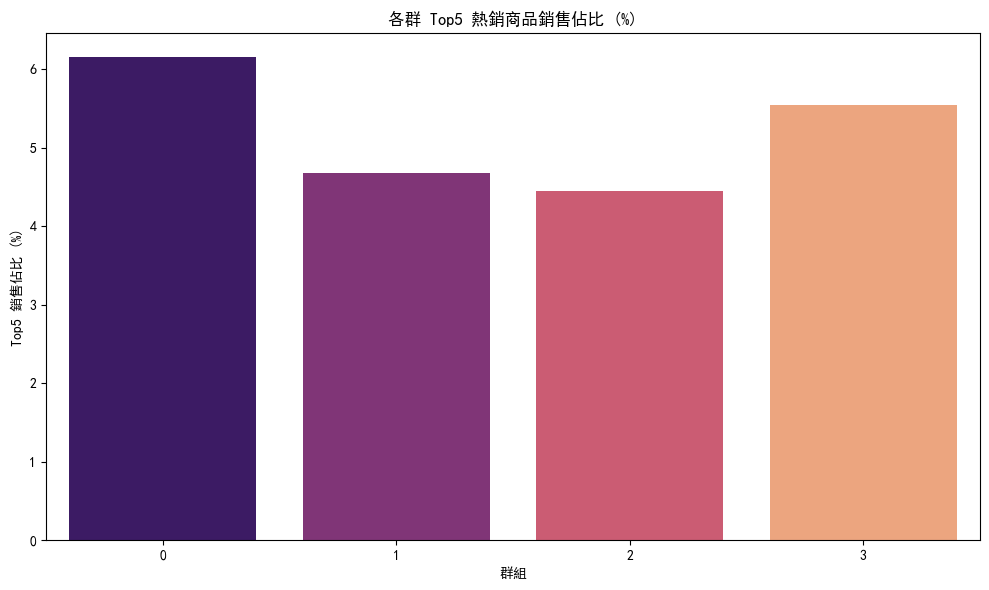

In [74]:
# 確保 df 已含 Cluster 欄位
print(df['Cluster'].value_counts())

# 建立一個空的 dict 儲存每個群組的 Top5 商品資料
top5_items_per_cluster = {}

# 儲存各群組的分析結果（包含總銷售、人均銷售、Top5熱銷商品佔比）
top5_ratio_result = []

# 計算每群的獨立客戶數（人數）
customer_count_per_cluster = df.groupby('Cluster')['CustomerID'].nunique()

for cluster in sorted(df['Cluster'].unique()):
    cluster_df = df[df['Cluster'] == cluster]

    # 總銷售金額
    total_sales = cluster_df['Total'].sum()

    # 每商品銷售彙總
    item_sales = (
        cluster_df
        .groupby('StockCode')['Total']
        .sum()
        .reset_index()
        .sort_values(by='Total', ascending=False)
    )

    # 取前5熱銷商品
    top5_items = item_sales.head(5)
    top5_items_per_cluster[cluster] = top5_items

    # Top5 商品銷售金額
    top5_total_sales = top5_items['Total'].sum()

    # Top5 熱銷商品佔比
    top5_ratio = top5_total_sales / total_sales * 100 if total_sales > 0 else 0

    # 人均銷售金額
    avg_sales_per_customer = total_sales / customer_count_per_cluster.loc[cluster]

    top5_ratio_result.append({
        'Cluster': cluster,
        'CustomerCount': customer_count_per_cluster.loc[cluster],
        'TotalSales': total_sales,
        'AvgSalesPerCustomer': round(avg_sales_per_customer, 2),
        'Top5Sales': top5_total_sales,
        'Top5Ratio(%)': round(top5_ratio, 2)
    })

# 轉成 DataFrame 顯示
top5_ratio_df = pd.DataFrame(top5_ratio_result)

print("各群組分析彙整：")
print(top5_ratio_df)

# 印出各群熱銷商品 TOP 5
for cluster, top5_df in top5_items_per_cluster.items():
    print(f"\nCluster {cluster} 的熱銷商品 TOP 5：")
    print(top5_df)
    
# 繪製人均銷售金額長條圖
plt.figure(figsize=(10,6))
sns.barplot(x='Cluster', y='AvgSalesPerCustomer', data=top5_ratio_df, palette='viridis')
plt.title('各群人均銷售金額')
plt.ylabel('人均銷售金額')
plt.xlabel('群組')
plt.tight_layout()
plt.show()

# 繪製 Top5 熱銷商品銷售佔比長條圖
plt.figure(figsize=(10,6))
sns.barplot(x='Cluster', y='Top5Ratio(%)', data=top5_ratio_df, palette='magma')
plt.title('各群 Top5 熱銷商品銷售佔比 (%)')
plt.ylabel('Top5 銷售佔比 (%)')
plt.xlabel('群組')
plt.tight_layout()
plt.show()

In [85]:
# 計算每位客戶購買次數
customer_purchases = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
customer_purchases.columns = ['CustomerID', 'PurchaseCount']

# 定義回購客戶(購買次數 > 2)
customer_purchases['IsRepeat'] = (customer_purchases['PurchaseCount'] > 4).astype(int)

# 刪除已有的 IsRepeat 欄位，避免合併衝突
if 'IsRepeat' in rfm.columns:
    rfm = rfm.drop(columns=['IsRepeat'])

# 合併回購標記
rfm = rfm.merge(customer_purchases[['CustomerID', 'IsRepeat']], on='CustomerID', how='left')

# 計算群組回購率
repeat_rate_by_cluster = rfm.groupby('Cluster')['IsRepeat'].mean().round(4) * 100
print("\n各群組回購率：\n", repeat_rate_by_cluster)
# CLV
rfm['CLV'] = rfm['Monetary'] * 0.5
clv_by_cluster = rfm.groupby('Cluster')['CLV'].mean().round(4)
print("CLV（毛利 50%）:\n", clv_by_cluster)

KeyError: 'Cluster'

Monetary 平均值: 1067.1168355949894


KeyError: 'CLV'

In [ ]:
import pandas as pd
import sqlite3
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import webbrowser

# 連接 SQLite 資料庫
conn = sqlite3.connect(r"/Users/ben/Desktop/sqlite-練習題/amazon.db")

# 從資料庫讀取資料表 commerce_data，並指定 CustomerID 為字串型態
df = pd.read_sql_query("SELECT * FROM commerce_data", conn, dtype={'CustomerID': str})

# 關閉連線
conn.close()
# 排除退貨單據
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
# 查看前五筆資料
print(df.head())

# 查看資料維度
print("資料形狀:", df.shape)

# 查看欄位資訊與缺失值狀況
print(df.info())

# 計算每欄位缺失比例
missing_ratio = df.isnull().mean()
print("缺失比例:\n", missing_ratio)

# 移除 Description 欄位
if 'Description' in df.columns:
    df.drop(['Description'], axis=1, inplace=True)

# 再次查看前五筆確認刪除成功
print(df.head())

# 將 CustomerID 缺失值填補為 'Unknown'
df['CustomerID'] = df['CustomerID'].fillna('Unknown')

# 把空字串（空白）也轉成 'Unknown'
df['CustomerID'] = df['CustomerID'].replace(r'^\s*$', 'Unknown', regex=True)

# 計算重複行數
print("重複行數:", df.duplicated().sum())

# 去除重複行
df = df.drop_duplicates()

# 查看數值型欄位的描述統計
print(df.describe())

# 確認 Unknown 數量
print("CustomerID 中 'Unknown' 數量:", (df['CustomerID'] == 'Unknown').sum())

# 數值欄位轉換
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce')

# 過濾異常資料
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
# 拆解時間欄位並轉成 datetime
df[['Date', 'Time']] = df['InvoiceDate'].str.split(' ', expand=True)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')
df.drop(columns=['InvoiceDate'], inplace=True)

# 計算每筆交易總額
df['Total'] = df['Quantity'] * df['UnitPrice']

# 確認結果
print("清理後資料筆數:", len(df))
print("CustomerID 'Unknown' 數量:", (df['CustomerID'] == 'Unknown').sum())
print(df[['Quantity', 'UnitPrice', 'Total']].describe())

# 新增欄位判斷是否會員
df['MemberType'] = df['CustomerID'].apply(lambda x: 'Non-Member' if x == 'Unknown' else 'Member')

# 計算各會員類型的訂單數（InvoiceNo 去重計數）
order_counts = df.groupby(['MemberType', 'InvoiceNo']).size().reset_index(name='OrderLines')
order_counts_per_member = order_counts.groupby('MemberType').size()

# 計算各會員類型總購買金額
total_spent = df.groupby('MemberType')['Total'].sum()

# 合併成表
summary = pd.DataFrame({
    'OrderCount': order_counts_per_member,
    'TotalSpent': total_spent
})

print("會員 vs 非會員 購買行為統計：")
print(summary)

# 日期轉換
df['Date'] = pd.to_datetime(df['Date'])

# 訂單月份
df['OrderMonth'] = df['Date'].dt.to_period('M')

# 首次購買月份 CohortMonth
cohort = df.groupby('CustomerID')['OrderMonth'].min().reset_index()
cohort.columns = ['CustomerID', 'CohortMonth']

# 避免重複欄位衝突
if 'CohortMonth' in df.columns:
    df = df.drop(columns=['CohortMonth'])

df = df.merge(cohort, on='CustomerID')

# 建立 CohortIndex
df['CohortIndex'] = (df['OrderMonth'].dt.year - df['CohortMonth'].dt.year) * 12 + \
                    (df['OrderMonth'].dt.month - df['CohortMonth'].dt.month)

# 每 cohort 每月的活躍顧客數
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()

# 每 cohort 初始人數
cohort_size = cohort_data[cohort_data['CohortIndex'] == 0][['CohortMonth', 'CustomerID']]
cohort_size.columns = ['CohortMonth', 'CohortSize']
cohort_data = cohort_data.merge(cohort_size, on='CohortMonth')

# 計算留存率
cohort_data['RetentionRate'] = cohort_data['CustomerID'] / cohort_data['CohortSize']
cohort_data['CohortMonth'] = cohort_data['CohortMonth'].astype(str)

# 過濾觀察期不足的 cohort
min_observed_months = 3
cohort_validity = df.groupby('CohortMonth')['CohortIndex'].max().reset_index()
cohort_validity.columns = ['CohortMonth', 'MaxIndex']
valid_cohorts = cohort_validity[cohort_validity['MaxIndex'] >= min_observed_months]['CohortMonth'].astype(str)
cohort_data = cohort_data[cohort_data['CohortMonth'].isin(valid_cohorts)]

# 建立留存率 & 留存人數表格
retention_rate_table = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='RetentionRate')
retention_count_table = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# 平均回購率（剔除 0 月）
kpi_retention = retention_rate_table.iloc[:, 1:].mean().mean()
print(f"\n回購率 KPI（平均留存率，不含第 0 月）: {kpi_retention:.2%}")

# 畫留存率熱力圖
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 8))
sns.heatmap(retention_rate_table, annot=True, fmt='.0%', cmap='Blues')
plt.title('Cohort 留存率（%）')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.tight_layout()
plt.show()

# 畫留存人數熱力圖
plt.figure(figsize=(12, 8))
sns.heatmap(retention_count_table, annot=True, fmt='.0f', cmap='Purples')
plt.title('Cohort 留存人數')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.tight_layout()
plt.show()
# RFM
# 1. 找出每個顧客最後一次消費日期
last_trans_date = df.groupby('CustomerID')['Date'].max()

# 2. 設定參考日期（分析當天的下一天）
snapshot_date = df['Date'].max() + pd.Timedelta(days=1)

# 3. 計算 Recency (距離參考日期的天數)
R = (snapshot_date - last_trans_date).dt.days

# 4. 計算 Frequency (消費頻率，訂單數)
F = df.groupby('CustomerID')['InvoiceNo'].nunique()

# 5. 計算 Monetary (消費金額總和)
M = df.groupby('CustomerID')['Total'].sum()

# 6. 合併成 RFM 表
rfm = pd.DataFrame({
    'Recency': R,
    'Frequency': F,
    'Monetary': M
})

# 7. 使用分位數過濾極端值
lower_q = 0.05
upper_q = 0.95

rfm_filtered = rfm[
    (rfm['Frequency'] >= rfm['Frequency'].quantile(lower_q)) &
    (rfm['Frequency'] <= rfm['Frequency'].quantile(upper_q)) &
    (rfm['Recency'] >= rfm['Recency'].quantile(lower_q)) &
    (rfm['Recency'] <= rfm['Recency'].quantile(upper_q)) &
    (rfm['Monetary'] >= rfm['Monetary'].quantile(lower_q)) &
    (rfm['Monetary'] <= rfm['Monetary'].quantile(upper_q))
].copy()

print(f"原始筆數: {len(rfm)}, 過濾後筆數: {len(rfm_filtered)}")

# 8. 查看過濾後的描述統計
print("過濾後 RFM 描述統計:")
print(rfm_filtered.describe())

# 9. 確認過濾後前幾筆
print("\n過濾後 RFM 資料預覽:")
print(rfm_filtered.head())


# Recency反向百分比排名，越近越大分數（5分為最高）
rfm_filtered['R_Score'] = (1 - rfm_filtered['Recency'].rank(pct=True)) * 5
rfm_filtered['R_Score'] = rfm_filtered['R_Score'].round().astype(int).clip(1,5)

# Frequency正向百分比排名，越頻繁分數越高
rfm_filtered['F_Score'] = rfm_filtered['Frequency'].rank(pct=True) * 5
rfm_filtered['F_Score'] = rfm_filtered['F_Score'].round().astype(int).clip(1,5)

# Monetary正向百分比排名，消費金額越大分數越高
rfm_filtered['M_Score'] = rfm_filtered['Monetary'].rank(pct=True) * 5
rfm_filtered['M_Score'] = rfm_filtered['M_Score'].round().astype(int).clip(1,5)

# 合併成 RFM 分數字串
rfm_filtered['RFM_Score'] = rfm_filtered['R_Score'].astype(str) + \
                            rfm_filtered['F_Score'].astype(str) + \
                            rfm_filtered['M_Score'].astype(str)

rfm_filtered.to_csv("rfm_filtered.csv")

print(rfm_filtered[['Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score']].head(10))
# 畫圖 + 匯出 HTML
fig = px.histogram(rfm_filtered, x='RFM_Score', color='RFM_Score',
                   title='RFM Score 分布',
                   labels={'RFM_Score': 'RFM 分數'},
                   color_discrete_sequence=px.colors.sequential.Viridis)

fig.update_layout(xaxis=dict(categoryorder='category ascending'))
html_path = "/Users/ben/Desktop/rfm_score_plot.html"
fig.write_html(html_path)
webbrowser.open(html_path)

# 讀取 RFM 檔案
rfm = pd.read_csv("/Users/ben/Downloads/rfm_filtered.csv")

# 取出 RFM 數值欄位
rfm_values = rfm[['Recency', 'Frequency', 'Monetary']].copy()

# 標準化
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_values)

# 使用標準化過的 rfm_scaled 進行 Elbow Method 分析
sse = []  # 存每個 k 對應的 inertia（SSE）

# 測試 k 值從 1 到 10
K_range = range(1, 16)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# 設定字體為 SimHei
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
# 繪製 Elbow 曲線
plt.figure(figsize=(8, 5))
plt.plot(K_range, sse, marker='o')
plt.xticks(K_range)
plt.xlabel('群數 k')
plt.ylabel('總體內平方誤差 (SSE)')
plt.title('Elbow Method 找最佳群數')
plt.grid(True)
plt.tight_layout()
plt.show()
# 執行 KMeans 分群
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 計算每群的平均值與數量
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)
cluster_summary['Count'] = rfm['Cluster'].value_counts().sort_index()
print("每群統計摘要：\n", cluster_summary)

# 匯出 CSV（含分群結果）
rfm.to_csv("/Users/ben/Desktop/rfm_kmeans_segmented.csv", index=False)

# 畫 3D 分群圖
fig = px.scatter_3d(rfm,
                    x='Recency', y='Frequency', z='Monetary',
                    color=rfm['Cluster'].astype(str),
                    title='KMeans RFM 分群（4群）',
                    labels={'Cluster': '群組'},
                    hover_data=['CustomerID', 'RFM_Score'])

# 匯出圖為 HTML 並自動打開
fig.write_html("/Users/ben/Desktop/rfm_kmeans_3d.html")
webbrowser.open("/Users/ben/Desktop/rfm_kmeans_3d.html")

print(rfm.columns)
print(rfm.head())

desc_stats = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).round(2)

print(desc_stats)

for col in ['Recency', 'Frequency', 'Monetary']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Cluster', y=col, data=rfm)
    plt.title(f'Cluster vs {col}')
    plt.show()
# 將 CustomerID 統一轉成字串型別（
df['CustomerID'] = df['CustomerID'].astype(str)
rfm['CustomerID'] = rfm['CustomerID'].astype(str)

# 把分群結果合併回原始 df（使用 CustomerID 做關聯）
df = df.merge(rfm[['CustomerID', 'Cluster']], on='CustomerID', how='inner')

# 建立月份欄位
df['Month'] = df['Date'].dt.to_period('M')
# 計算每個群集、每月的總消費金額
monthly_cluster = df.groupby(['Cluster', 'Month'])['Total'].sum().reset_index()

# 繪圖
plt.figure(figsize=(12, 6))
for cluster in sorted(monthly_cluster['Cluster'].unique()):
    cluster_data = monthly_cluster[monthly_cluster['Cluster'] == cluster]
    plt.plot(cluster_data['Month'].astype(str), cluster_data['Total'], label=f'Cluster {cluster}')

plt.title("各群客戶每月總消費金額變化")
plt.xlabel("月份")
plt.ylabel("總消費金額")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# 確保 df 已含 Cluster 欄位
print(df['Cluster'].value_counts())

# 建立一個空的 dict 儲存每個群組的 Top5 商品資料
top5_items_per_cluster = {}

# 儲存各群組的分析結果（包含總銷售、人均銷售、Top5熱銷商品佔比）
top5_ratio_result = []

# 計算每群的獨立客戶數（人數）
customer_count_per_cluster = df.groupby('Cluster')['CustomerID'].nunique()

for cluster in sorted(df['Cluster'].unique()):
    cluster_df = df[df['Cluster'] == cluster]

    # 總銷售金額
    total_sales = cluster_df['Total'].sum()

    # 每商品銷售彙總
    item_sales = (
        cluster_df
        .groupby('StockCode')['Total']
        .sum()
        .reset_index()
        .sort_values(by='Total', ascending=False)
    )

    # 取前5熱銷商品
    top5_items = item_sales.head(5)
    top5_items_per_cluster[cluster] = top5_items

    # Top5 商品銷售金額
    top5_total_sales = top5_items['Total'].sum()

    # Top5 熱銷商品佔比
    top5_ratio = top5_total_sales / total_sales * 100 if total_sales > 0 else 0

    # 人均銷售金額
    avg_sales_per_customer = total_sales / customer_count_per_cluster.loc[cluster]

    top5_ratio_result.append({
        'Cluster': cluster,
        'CustomerCount': customer_count_per_cluster.loc[cluster],
        'TotalSales': total_sales,
        'AvgSalesPerCustomer': round(avg_sales_per_customer, 2),
        'Top5Sales': top5_total_sales,
        'Top5Ratio(%)': round(top5_ratio, 2)
    })

# 轉成 DataFrame 顯示
top5_ratio_df = pd.DataFrame(top5_ratio_result)

print("各群組分析彙整：")
print(top5_ratio_df)

# 印出各群熱銷商品 TOP 5
for cluster, top5_df in top5_items_per_cluster.items():
    print(f"\nCluster {cluster} 的熱銷商品 TOP 5：")
    print(top5_df)

# 繪製人均銷售金額長條圖
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgSalesPerCustomer', data=top5_ratio_df, palette='viridis')
plt.title('各群人均銷售金額')
plt.ylabel('人均銷售金額')
plt.xlabel('群組')
plt.tight_layout()
plt.show()

# 繪製 Top5 熱銷商品銷售佔比長條圖
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Top5Ratio(%)', data=top5_ratio_df, palette='magma')
plt.title('各群 Top5 熱銷商品銷售佔比 (%)')
plt.ylabel('Top5 銷售佔比 (%)')
plt.xlabel('群組')
plt.tight_layout()
plt.show()
# 計算每位客戶購買次數
customer_purchases = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
customer_purchases.columns = ['CustomerID', 'PurchaseCount']

# 定義回購客戶(購買次數 > 2)
customer_purchases['IsRepeat'] = (customer_purchases['PurchaseCount'] > 3).astype(int)

# 刪除已有的 IsRepeat 欄位，避免合併衝突
if 'IsRepeat' in rfm.columns:
    rfm = rfm.drop(columns=['IsRepeat'])

# 合併回購標記
rfm = rfm.merge(customer_purchases[['CustomerID', 'IsRepeat']], on='CustomerID', how='left')

# 計算群組回購率
repeat_rate_by_cluster = rfm.groupby('Cluster')['IsRepeat'].mean().round(4) * 100
print("\n各群組回購率：\n", repeat_rate_by_cluster)
# CLV
rfm['CLV'] = rfm['Monetary'] * 0.5
clv_by_cluster = rfm.groupby('Cluster')['CLV'].mean().round(4)
print("CLV（毛利 50%）:\n", clv_by_cluster)

In [ ]:
import os
import pandas as pd
import sqlite3
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import webbrowser

# 建立 outputs 目錄
OUTPUT_DIR = "./outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_data(db_path):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query("SELECT * FROM commerce_data", conn, dtype={'CustomerID': str})
    conn.close()
    return df

def preprocess_data(df):
    df = df[~df['InvoiceNo'].astype(str).str.startswith('C')].copy()  # 排除退貨單
    df = df.drop_duplicates()
    df['CustomerID'] = df['CustomerID'].fillna('Unknown').replace(r'^\s*$', 'Unknown', regex=True)
    df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
    df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce')
    df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)].copy()
    df[['Date', 'Time']] = df['InvoiceDate'].str.split(' ', expand=True)
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')
    df['Total'] = df['Quantity'] * df['UnitPrice']
    df['MemberType'] = df['CustomerID'].apply(lambda x: 'Non-Member' if x == 'Unknown' else 'Member')
    df = df.drop(columns=['InvoiceDate', 'Time'], errors='ignore')
    return df

def member_vs_nonmember_analysis(df):
    summary = df.groupby('MemberType').agg(
        OrderCount=('InvoiceNo', 'nunique'),
        TotalSpent=('Total', 'sum')
    )
    print("\n會員 vs 非會員 購買行為統計：")
    print(summary)

def cohort_analysis(df):
    df['OrderMonth'] = df['Date'].dt.to_period('M')
    cohort = df.groupby('CustomerID')['OrderMonth'].min().reset_index()
    cohort.columns = ['CustomerID', 'CohortMonth']
    df = df.merge(cohort, on='CustomerID')
    df['CohortIndex'] = (df['OrderMonth'].dt.year - df['CohortMonth'].dt.year) * 12 + \
                        (df['OrderMonth'].dt.month - df['CohortMonth'].dt.month)
    cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
    cohort_size = cohort_data[cohort_data['CohortIndex'] == 0][['CohortMonth', 'CustomerID']]
    cohort_size.columns = ['CohortMonth', 'CohortSize']
    cohort_data = cohort_data.merge(cohort_size, on='CohortMonth')
    cohort_data['RetentionRate'] = cohort_data['CustomerID'] / cohort_data['CohortSize']
    cohort_data['CohortMonth'] = cohort_data['CohortMonth'].astype(str)
    min_observed_months = 3
    cohort_validity = df.groupby('CohortMonth')['CohortIndex'].max().reset_index()
    cohort_validity.columns = ['CohortMonth', 'MaxIndex']
    valid_cohorts = cohort_validity[cohort_validity['MaxIndex'] >= min_observed_months]['CohortMonth'].astype(str)
    cohort_data = cohort_data[cohort_data['CohortMonth'].isin(valid_cohorts)]

    retention_rate_table = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='RetentionRate')
    retention_count_table = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

    kpi_retention = retention_rate_table.iloc[:, 1:].mean().mean()
    print(f"\n回購率 KPI（平均留存率，不含第 0 月）: {kpi_retention:.2%}")

    plt.rcParams['font.family'] = 'SimHei'
    plt.rcParams['axes.unicode_minus'] = False

    plt.figure(figsize=(12, 8))
    sns.heatmap(retention_rate_table, annot=True, fmt='.0%', cmap='Blues')
    plt.title('Cohort 留存率（%）')
    plt.ylabel('Cohort Month')
    plt.xlabel('Months Since First Purchase')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/cohort_retention_rate_heatmap.png")
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.heatmap(retention_count_table, annot=True, fmt='.0f', cmap='Purples')
    plt.title('Cohort 留存人數')
    plt.ylabel('Cohort Month')
    plt.xlabel('Months Since First Purchase')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/cohort_retention_count_heatmap.png")
    plt.show()

def score_rfm(rfm):
    rfm['R_Score'] = (1 - rfm['Recency'].rank(pct=True)) * 5
    rfm['F_Score'] = rfm['Frequency'].rank(pct=True) * 5
    rfm['M_Score'] = rfm['Monetary'].rank(pct=True) * 5
    for col in ['R_Score', 'F_Score', 'M_Score']:
        rfm[col] = rfm[col].round().astype(int).clip(1, 5)
    rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
    return rfm

def rfm_analysis(df):
    lower_q = 0.05
    upper_q = 0.95
    snapshot_date = df['Date'].max() + pd.Timedelta(days=1)
    R = (snapshot_date - df.groupby('CustomerID')['Date'].max()).dt.days
    F = df.groupby('CustomerID')['InvoiceNo'].nunique()
    M = df.groupby('CustomerID')['Total'].sum()
    rfm = pd.DataFrame({'Recency': R, 'Frequency': F, 'Monetary': M})

    # 只針對 Recency 進行上界過濾，避免過濾掉活躍客戶
    rfm_filtered = rfm[
        (rfm['Recency'] <= rfm['Recency'].quantile(upper_q)) &
        (rfm['Frequency'] >= rfm['Frequency'].quantile(lower_q)) &
        (rfm['Frequency'] <= rfm['Frequency'].quantile(upper_q)) &
        (rfm['Monetary'] >= rfm['Monetary'].quantile(lower_q)) &
        (rfm['Monetary'] <= rfm['Monetary'].quantile(upper_q))
    ].copy()

    print(f"原始顧客數: {len(rfm)}, 過濾後顧客數: {len(rfm_filtered)}")
    print("\n過濾後 RFM 描述統計：")
    print(rfm_filtered.describe())

    rfm_filtered = score_rfm(rfm_filtered)
    rfm_filtered.reset_index(inplace=True)  # 將 CustomerID 從 index 變欄位

    print("\nRFM 分數預覽：")
    print(rfm_filtered[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score']].head(10))

    fig = px.histogram(
        rfm_filtered,
        x='RFM_Score',
        color='RFM_Score',
        title='RFM Score 分布',
        labels={'RFM_Score': 'RFM 分數'},
        color_discrete_sequence=px.colors.sequential.Viridis
    )
    fig.update_layout(xaxis=dict(categoryorder='category ascending'))

    rfm_html = f"{OUTPUT_DIR}/rfm_score_distribution.html"
    fig.write_html(rfm_html)
    webbrowser.open(rfm_html)

    rfm_filtered.to_csv(f"{OUTPUT_DIR}/rfm_filtered.csv", index=False)

    return rfm_filtered
def kmeans_clustering(rfm):
    rfm_values = rfm[['Recency', 'Frequency', 'Monetary']].copy()
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_values)

    sse = []
    K_range = range(1, 16)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(rfm_scaled)
        sse.append(kmeans.inertia_)

    plt.rcParams['font.family'] = 'SimHei'
    plt.rcParams['axes.unicode_minus'] = False

    plt.figure(figsize=(8, 5))
    plt.plot(K_range, sse, marker='o')
    plt.xticks(K_range)
    plt.xlabel('群數 k')
    plt.ylabel('總體內平方誤差 (SSE)')
    plt.title('Elbow Method 找最佳群數')
    plt.grid(True)
    plt.tight_layout()
    elbow_path = f"{OUTPUT_DIR}/elbow_method.png"
    plt.savefig(elbow_path)
    plt.show()

    # 預設使用 4 群
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

    cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)
    cluster_summary['Count'] = rfm['Cluster'].value_counts().sort_index()
    print("每群統計摘要：\n", cluster_summary)

    rfm.to_csv(f"{OUTPUT_DIR}/rfm_kmeans_segmented.csv", index=False)

    fig = px.scatter_3d(rfm,
                        x='Recency', y='Frequency', z='Monetary',
                        color=rfm['Cluster'].astype(str),
                        title='KMeans RFM 分群（4群）',
                        labels={'Cluster': '群組'},
                        hover_data=['CustomerID', 'RFM_Score'])
    rfm_3d_html = f"{OUTPUT_DIR}/rfm_kmeans_3d.html"
    fig.write_html(rfm_3d_html)
    webbrowser.open(rfm_3d_html)

    return rfm
def cluster_sales_analysis(df, rfm):
    df['CustomerID'] = df['CustomerID'].astype(str)
    rfm['CustomerID'] = rfm['CustomerID'].astype(str)

    print("原始 df 客戶數:", df['CustomerID'].nunique())
    print("rfm 資料客戶數:", rfm['CustomerID'].nunique())

    # 僅保留在 RFM 分群中的客戶
    df_rfm = df[df['CustomerID'].isin(rfm['CustomerID'])].copy()

    # 合併分群結果
    df_rfm = df_rfm.merge(rfm[['CustomerID', 'Cluster']], on='CustomerID', how='inner')

    print("合併後客戶數:", df_rfm['CustomerID'].nunique())

    # 各群每月消費趨勢
    df_rfm['Month'] = df_rfm['Date'].dt.to_period('M')
    monthly_cluster = df_rfm.groupby(['Cluster', 'Month'])['Total'].sum().reset_index()

    plt.figure(figsize=(12, 6))
    for cluster in sorted(monthly_cluster['Cluster'].unique()):
        cluster_data = monthly_cluster[monthly_cluster['Cluster'] == cluster]
        plt.plot(cluster_data['Month'].astype(str), cluster_data['Total'], label=f'Cluster {cluster}')
    plt.title("各群客戶每月總消費金額變化")
    plt.xlabel("月份")
    plt.ylabel("總消費金額")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\n各群交易筆數分布：")
    print(df_rfm['Cluster'].value_counts())

    print("\n各群獨立客戶數分布：")
    print(df_rfm.groupby('Cluster')['CustomerID'].nunique())

    # 計算各群客戶數（獨立客戶數）
    customer_count_per_cluster = df_rfm.groupby('Cluster')['CustomerID'].nunique()

    top5_items_per_cluster = []
    top5_ratio_result = []

    for cluster in sorted(df_rfm['Cluster'].unique()):
        cluster_df = df_rfm[df_rfm['Cluster'] == cluster]

        total_sales = cluster_df['Total'].sum()

        # 每群商品銷售總額
        item_sales = cluster_df.groupby('StockCode')['Total'].sum().reset_index().sort_values(by='Total', ascending=False)

        # Top5 商品
        top5_items = item_sales.head(5)
        top5_items_per_cluster.append((cluster, top5_items))

        top5_total_sales = top5_items['Total'].sum()

        # Top5 銷售佔比
        top5_ratio = top5_total_sales / total_sales * 100 if total_sales > 0 else 0

        # 人均銷售額
        avg_sales_per_customer = total_sales / customer_count_per_cluster.loc[cluster]

        top5_ratio_result.append({
            'Cluster': cluster,
            'CustomerCount': customer_count_per_cluster.loc[cluster],
            'TotalSales': total_sales,
            'AvgSalesPerCustomer': round(avg_sales_per_customer, 2),
            'Top5Sales': top5_total_sales,
            'Top5Ratio(%)': round(top5_ratio, 2)
        })

    top5_ratio_df = pd.DataFrame(top5_ratio_result)
    print("\n各群組銷售分析彙整：")
    print(top5_ratio_df)

    for cluster, top5_df in top5_items_per_cluster:
        print(f"\nCluster {cluster} 熱銷商品 TOP 5：")
        print(top5_df)

    # 繪製人均銷售額與Top5銷售佔比
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Cluster', y='AvgSalesPerCustomer', data=top5_ratio_df, palette='viridis')
    plt.title('各群人均銷售金額')
    plt.ylabel('人均銷售金額')
    plt.xlabel('群組')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Cluster', y='Top5Ratio(%)', data=top5_ratio_df, palette='magma')
    plt.title('各群 Top5 熱銷商品銷售佔比 (%)')
    plt.ylabel('Top5 銷售佔比 (%)')
    plt.xlabel('群組')
    plt.tight_layout()
    plt.show()

    # 計算回購率（購買超過3次算回購）
    customer_purchases = df_rfm.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
    customer_purchases.columns = ['CustomerID', 'PurchaseCount']
    customer_purchases['IsRepeat'] = (customer_purchases['PurchaseCount'] > 3).astype(int)

    if 'IsRepeat' in rfm.columns:
        rfm = rfm.drop(columns=['IsRepeat'])

    rfm = rfm.merge(customer_purchases[['CustomerID', 'IsRepeat']], on='CustomerID', how='left')

    repeat_rate_by_cluster = rfm.groupby('Cluster')['IsRepeat'].mean().round(4) * 100
    print("\n回購率 (購買超過3次占比) by Cluster:")
    print(repeat_rate_by_cluster)

    # CLV（毛利率50%）
    rfm['CLV'] = rfm['Monetary'] * 0.5
    clv_by_cluster = rfm.groupby('Cluster')['CLV'].mean().round(4)
    print("\nCLV（毛利 50%） by Cluster:")
    print(clv_by_cluster)


def descriptive_stats(df):
    print("\n資料形狀:", df.shape)
    print("欄位資訊:")
    print(df.info())
    print("\n缺失比例:")
    print(df.isna().mean())
    print("\nCustomerID 中 'Unknown' 數量:", (df['CustomerID'] == 'Unknown').sum())
    print("\n數值描述統計:")
    print(df[['Quantity', 'UnitPrice', 'Total']].describe())

def main():
    DB_PATH = "/Users/ben/Desktop/python/practice/data_practice/amazon.db"  # 請自行調整相對路徑

    df = load_data(DB_PATH)
    df = preprocess_data(df)

    descriptive_stats(df)

    member_vs_nonmember_analysis(df)

    cohort_analysis(df)

    rfm = rfm_analysis(df)

    rfm = kmeans_clustering(rfm)

    cluster_sales_analysis(df, rfm)

if __name__ == "__main__":
    main()
